In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# 1. Load dataset
df = pd.read_csv("ready_fraud_detection_dataset.csv")

# 2. Create numeric label
df['label'] = df['fraudulent'].map({'f': 0, 't': 1})

# 3. Drop any rows with missing full_text (just in case)
df = df.dropna(subset=['full_text'])

# 4. Train-test split (80:20)
X = df['full_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [2]:
# 🔍 Debugging Block

print("🚨 DEBUGGING CHECKS 🚨")
print("Total rows in original df:", len(df))
print("NaNs in full_text:", df['full_text'].isna().sum())
print("Class distribution in full dataset:\n", df['label'].value_counts())
print("Size of X_train:", len(X_train))
print("Size of y_train:", len(y_train))

# Check for NaNs in training data
print("NaNs in X_train:", X_train.isna().sum())
print("NaNs in y_train:", y_train.isna().sum())

# Optional: Check if X_train has any empty strings
empty_text_count = (X_train.str.strip() == "").sum()
print("Empty string entries in X_train:", empty_text_count)

# Sanity check: X_train must not be empty
assert len(X_train) > 0, "❌ X_train is EMPTY!"
assert X_train.isna().sum() == 0, "❌ X_train contains NaNs!"


🚨 DEBUGGING CHECKS 🚨
Total rows in original df: 17880
NaNs in full_text: 0
Class distribution in full dataset:
 label
0    17014
1      866
Name: count, dtype: int64
Size of X_train: 14304
Size of y_train: 14304
NaNs in X_train: 0
NaNs in y_train: 0
Empty string entries in X_train: 0


In [3]:
#  5. Convert X_train to DataFrame (required by RandomUnderSampler)
X_train_df = pd.DataFrame({'text': X_train.values})

# ✅ Check the length before resampling
assert len(X_train_df) > 0, "X_train is empty!"

# 6. Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_df, y_train)

# 7. Manual Oversampling (repeat minority class)
df_rus = pd.DataFrame({'text': X_rus['text'], 'label': y_rus})
minority = df_rus[df_rus['label'] == 1]
majority = df_rus[df_rus['label'] == 0]
minority_oversampled = minority.sample(n=len(majority), replace=True, random_state=42)

# 8. Combine and shuffle the balanced data
df_balanced = pd.concat([majority, minority_oversampled]).sample(frac=1, random_state=42)

# Final balanced train data
X_train_balanced = df_balanced['text'].tolist()
y_train_balanced = df_balanced['label'].tolist()


✅ Balanced training set label counts: Counter({0: 693, 1: 693})


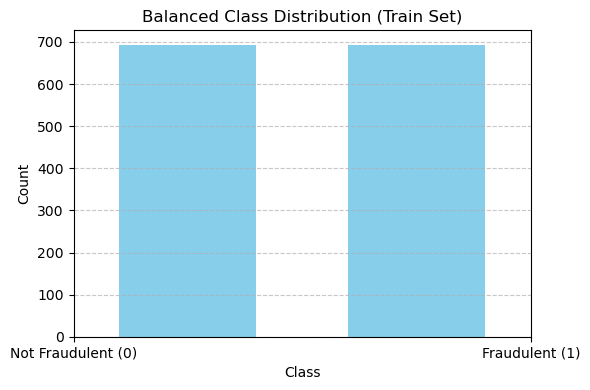

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# Print label distribution
print("✅ Balanced training set label counts:", Counter(y_train_balanced))

# Create a histogram
plt.figure(figsize=(6, 4))
plt.hist(y_train_balanced, bins=2, rwidth=0.6, color='skyblue')
plt.xticks([0, 1], ['Not Fraudulent (0)', 'Fraudulent (1)'])
plt.title("Balanced Class Distribution (Train Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [5]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize balanced training texts
train_encodings = tokenizer(
    X_train_balanced,
    padding='max_length',       # ensures same length for all
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Tokenize original unbalanced test texts
test_encodings = tokenizer(
    list(X_test),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)



In [6]:
# Sample index to inspect
sample_idx = 5

# Show token IDs
print("🔢 Input IDs:", train_encodings['input_ids'][sample_idx])

# Show attention mask
print("🧠 Attention Mask:", train_encodings['attention_mask'][sample_idx])

# Decode tokens back to text for readability
decoded_text = tokenizer.decode(train_encodings['input_ids'][sample_idx], skip_special_tokens=True)
print("📝 Decoded Text:\n", decoded_text)


🔢 Input IDs: tensor([  101,  2708,  4082,  2961,  2522,  2080,  2103, 22345,  7126,  3655,
         2000, 10938,  2037,  4279,  2011, 16003,  2037,  8144,  3977,  1998,
         6631, 18988,  7300,  1998,  4725,  2057,  2079,  2023,  2011,  5094,
         3655,  2000,  8970,  3291, 15058,  2094, 21423,  4725,  2029,  2393,
         8526,  1037,  2172,  7289,  2451,  1997, 17088,  1999, 13729,  3923,
         1998,  2591,  7860,  2004,  1037,  2765,  3655, 15697,  2625,  2270,
         4219,  2000,  3618, 23382,  3466,  1998,  3623,  2334,  3105,  4325,
         2083,  2062, 20213, 28681,  3686,  2057,  2031,  2949,  2062,  2084,
         3938,  2107,  3454,  2007,  2058,  2753,  3655,  4969, 24471,  2140,
        12740, 18939,  2620,  4402, 28311,  2509,  2063,  2629, 10354,  2278,
         2620, 17914, 24096,  2575, 21619,  2063,  2620,  9468,  2497,  2692,
         2620,  2475,  2278,  2692,  2094, 16147,  7959, 27531,  2549, 29292,
         2692, 22407, 20958,  2683, 19317,  2620,  

In [7]:
print(f"Length of encodings: {len(train_encodings['input_ids'])}")
print(f"Length of labels: {len(y_train_balanced)}")


Length of encodings: 1386
Length of labels: 1386


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if isinstance(self.labels, (list, torch.Tensor)):
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item


In [9]:
class BERTCNNClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2):
        super(BERTCNNClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x).squeeze(2)
        x = self.dropout(x)
        return self.fc(x)


class BERTLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_size=256, num_classes=2, num_layers=1, bidirectional=True):
        super(BERTLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)


class BERTCNNLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', cnn_out_channels=256, lstm_hidden_size=128, num_classes=2, num_layers=1, bidirectional=True):
        super(BERTCNNLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=cnn_out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=lstm_hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(lstm_hidden_size * 2 if bidirectional else lstm_hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = self.relu(self.conv1(x.permute(0, 2, 1))).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)


In [10]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, save_path='training_metrics.csv'):
    model.train()
    stats = []

    for epoch in range(num_epochs):
        epoch_loss, all_preds, all_labels = 0.0, [], []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro')
        rec = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        cm = confusion_matrix(all_labels, all_preds).tolist()

        stats.append({
            "Epoch": epoch + 1, "Loss": epoch_loss, "Accuracy": acc,
            "Precision": prec, "Recall": rec, "F1_score": f1, "Confusion_Matrix": cm
        })

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

    df_stats = pd.DataFrame(stats)
    df_stats.to_csv(save_path, index=False)
    return df_stats


In [11]:
def evaluate_model(model, test_loader, device, save_path='test_metrics.csv'):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds).tolist()

    print("\n📊 Test Set Evaluation:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    df = pd.DataFrame([{
        "Dataset": "Test", "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1_score": f1, "Confusion_Matrix": cm
    }])
    df.to_csv(save_path, index=False)
    return df



# Prepare dataset and dataloader
train_dataset = TextDataset(train_encodings, y_train_balanced)
test_dataset = TextDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Setup device, loss function, and example optimizer (you can reuse it or define per model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()


In [12]:
# Example: Using BERT + CNN
model = BERTCNNClassifier().to(device)
optimizer = Adam(model.parameters(), lr=2e-5)
train_stats = train_model(model, train_loader, criterion, optimizer, device, save_path="Results/bert_cnn_train.csv")

Epoch 1/10 - Loss: 50.4639, Acc: 0.6905, Prec: 0.6908, Rec: 0.6905, F1: 0.6904
Epoch 2/10 - Loss: 27.2049, Acc: 0.8730, Prec: 0.8731, Rec: 0.8730, F1: 0.8730
Epoch 3/10 - Loss: 13.3464, Acc: 0.9452, Prec: 0.9452, Rec: 0.9452, F1: 0.9452
Epoch 4/10 - Loss: 6.2778, Acc: 0.9827, Prec: 0.9827, Rec: 0.9827, F1: 0.9827
Epoch 5/10 - Loss: 3.3748, Acc: 0.9870, Prec: 0.9870, Rec: 0.9870, F1: 0.9870
Epoch 6/10 - Loss: 1.0201, Acc: 0.9971, Prec: 0.9971, Rec: 0.9971, F1: 0.9971
Epoch 7/10 - Loss: 0.5973, Acc: 0.9986, Prec: 0.9986, Rec: 0.9986, F1: 0.9986
Epoch 8/10 - Loss: 0.1273, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
Epoch 9/10 - Loss: 0.0663, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
Epoch 10/10 - Loss: 0.0461, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


In [13]:
test_stats = evaluate_model(model, test_loader, device, save_path="Results/bert_cnn_test.csv")



📊 Test Set Evaluation:
Accuracy: 0.9444, Precision: 0.7287, Recall: 0.9296, F1: 0.7918
Confusion Matrix:
 [[3219, 184], [15, 158]]


In [14]:
model = BERTLSTMClassifier().to(device)
optimizer = Adam(model.parameters(), lr=2e-5)
train_stats = train_model(model, train_loader, criterion, optimizer, device, save_path="Results/bert_lstm_train.csv")

Epoch 1/10 - Loss: 45.9871, Acc: 0.7273, Prec: 0.7289, Rec: 0.7273, F1: 0.7268
Epoch 2/10 - Loss: 22.2946, Acc: 0.8997, Prec: 0.8999, Rec: 0.8997, F1: 0.8997
Epoch 3/10 - Loss: 11.8867, Acc: 0.9509, Prec: 0.9510, Rec: 0.9509, F1: 0.9509
Epoch 4/10 - Loss: 8.5415, Acc: 0.9704, Prec: 0.9704, Rec: 0.9704, F1: 0.9704
Epoch 5/10 - Loss: 3.7849, Acc: 0.9885, Prec: 0.9885, Rec: 0.9885, F1: 0.9885
Epoch 6/10 - Loss: 1.4972, Acc: 0.9957, Prec: 0.9957, Rec: 0.9957, F1: 0.9957
Epoch 7/10 - Loss: 0.5625, Acc: 0.9993, Prec: 0.9993, Rec: 0.9993, F1: 0.9993
Epoch 8/10 - Loss: 0.2749, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
Epoch 9/10 - Loss: 0.2011, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
Epoch 10/10 - Loss: 0.1547, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


In [15]:
test_stats = evaluate_model(model, test_loader, device, save_path="Results/bert_lstm_test.csv")


📊 Test Set Evaluation:
Accuracy: 0.9371, Precision: 0.7116, Recall: 0.9203, F1: 0.7735
Confusion Matrix:
 [[3195, 208], [17, 156]]


In [16]:
model = BERTCNNLSTMClassifier().to(device)
optimizer = Adam(model.parameters(), lr=2e-5)
train_stats = train_model(model, train_loader, criterion, optimizer, device, save_path="Results/bert_cnn_lstm_train.csv")

Epoch 1/10 - Loss: 53.5396, Acc: 0.6609, Prec: 0.6620, Rec: 0.6609, F1: 0.6603
Epoch 2/10 - Loss: 35.4373, Acc: 0.8405, Prec: 0.8406, Rec: 0.8405, F1: 0.8405
Epoch 3/10 - Loss: 22.2903, Acc: 0.9206, Prec: 0.9208, Rec: 0.9206, F1: 0.9206
Epoch 4/10 - Loss: 14.3863, Acc: 0.9531, Prec: 0.9531, Rec: 0.9531, F1: 0.9531
Epoch 5/10 - Loss: 9.8507, Acc: 0.9704, Prec: 0.9704, Rec: 0.9704, F1: 0.9704
Epoch 6/10 - Loss: 8.4736, Acc: 0.9733, Prec: 0.9735, Rec: 0.9733, F1: 0.9733
Epoch 7/10 - Loss: 5.3086, Acc: 0.9848, Prec: 0.9849, Rec: 0.9848, F1: 0.9848
Epoch 8/10 - Loss: 3.4705, Acc: 0.9935, Prec: 0.9935, Rec: 0.9935, F1: 0.9935
Epoch 9/10 - Loss: 3.3103, Acc: 0.9928, Prec: 0.9928, Rec: 0.9928, F1: 0.9928
Epoch 10/10 - Loss: 2.0778, Acc: 0.9964, Prec: 0.9964, Rec: 0.9964, F1: 0.9964


In [17]:
test_stats = evaluate_model(model, test_loader, device, save_path="Results/bert_cnn_lstm_test.csv")


📊 Test Set Evaluation:
Accuracy: 0.9379, Precision: 0.7138, Recall: 0.9235, F1: 0.7761
Confusion Matrix:
 [[3197, 206], [16, 157]]
